In [3]:
%%writefile network.py
import torch
import torch.nn as nn
import torch.nn.functional as F

#Embedder network: feature space --> latent space
class Embedder(nn.Module):
    def __init__(self, args):
        super(Embedder, self).__init__()
        self.feature_dim       = args.feature_dim
        self.hidden_dim      = args.hidden_dim
        self.num_layers       = args.num_layers
        self.batch_size       = args.batch_size
        self.sequence_length  = args.sequence_length
        
        self.emb_rnn = nn.GRU(input_size=self.feature_dim, hidden_size=self.hidden_dim, num_layers = self.num_layers, batch_first=True)
        self.fc  = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x): 
        h0     =  torch.randn(self.num_layers , self.batch_size, self.hidden_dim)
        out, _ = self.emb_rnn(x, h0) 
        logit = self.fc(out)
        latent = self.activation(logit)
        return latent
    

#Recovery network: latent space --> feature space
class Recovery(nn.Module):
    def __init__(self, args):
        super(Recovery, self).__init__()
        self.hidden_dim      = args.hidden_dim
        self.num_layers       = args.num_layers
        self.batch_size       = args.batch_size
        self.sequence_length  = args.sequence_length
        self.output_size      = args.feature_dim
        
        self.rec_rnn = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers = self.num_layers, batch_first=True)
        self.fc  = nn.Linear(self.hidden_dim, self.output_size)

    def forward(self, x): 
        h0     =  torch.randn(self.num_layers , self.batch_size, self.hidden_dim)
        out, _ = self.rec_rnn(x, h0) 
        x_tilde = self.fc(out)
       
        return x_tilde
    
#Supervisor network: latent space --> latent space
class Supervisor(nn.Module):
    def __init__(self, args):
        super(Supervisor, self).__init__()
        self.hidden_dim      = args.hidden_dim
        self.num_layers       = args.num_layers
        self.batch_size       = args.batch_size
        self.sequence_length  = args.sequence_length
        
        self.sup_rnn = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers = self.num_layers-1, batch_first=True)
        self.fc  = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.activation = nn.Sigmoid()
        
    def forward(self, H): 
        h0     =  torch.randn(self.num_layers-1, self.batch_size, self.hidden_dim)
        out, _ = self.sup_rnn(H, h0) 
        H_out = self.fc(out)
        H_out = self.activation(H_out) 
        
        return H_out

#Generator network: random seed Z --> latent space representation
class Generator(nn.Module):
    def __init__(self, args):
        super(Generator, self).__init__()
        self.Z_dim       = args.Z_dim
        self.hidden_dim      = args.hidden_dim
        self.num_layers       = args.num_layers
        self.batch_size       = args.batch_size
        self.sequence_length  = args.sequence_length
        
        self.gen_rnn = nn.GRU(input_size=self.Z_dim, hidden_size=self.hidden_dim, num_layers = self.num_layers, batch_first=True)
        self.fc  = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.activation = nn.Sigmoid()
        
    def forward(self, Z): 
        h0     =  torch.randn(self.num_layers, self.batch_size, self.hidden_dim)
        out, _ = self.gen_rnn(Z, h0) 
        logits = self.fc(out)
        H_hat = self.activation(logits) 
        
        return H_hat

#Discriminator: latent space --> classification
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.hidden_dim      = args.hidden_dim
        self.num_layers       = args.num_layers
        self.batch_size       = args.batch_size
        self.sequence_length  = args.sequence_length
        
        self.disc_rnn = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers = self.num_layers, batch_first=True)
        self.disc_fc  = nn.Linear(self.hidden_dim, 1)
        
    def forward(self, H): 
        h0     =  torch.randn(self.num_layers, self.batch_size, self.hidden_dim)
        out, _ = self.disc_rnn(H, h0) 
        logits = self.disc_fc(out).squeeze(-1)
        
        return logits
    
    
class TimeGAN(nn.Module):
    def __init__(self, args):
        super(TimeGAN, self).__init__()
        self.device = args.device
        self.feature = args.feature_dim
        self.Z_dim = args.Z_dim
        self.hidden_dim = args.hidden_dim
        self.seq_len = args.sequence_length
        self.batch_size = args.batch_size

        self.embedder = Embedder(args)
        self.recovery = Recovery(args)
        self.generator = Generator(args)
        self.supervisor = Supervisor(args)
        self.discriminator = Discriminator(args)
        
    def _recovery_forward(self, X): 
        H = self.embedder(X)
        X_tilde = self.recovery(H)
        
        #supervisor loss
        H_hat_sup = self.supervisor(H)
        G_loss_sup = F.mse_loss(H_hat_sup[:,:-1,:], H[:,1:,:])
        
        #joint loss of reconstruction and supervision
        E_loss_T0 = F.mse_loss(X_tilde, X)
        E_loss0 = 10 * torch.sqrt(E_loss_T0)
        E_loss = E_loss0 + 0.1 * G_loss_sup
        
        return E_loss, E_loss0, E_loss_T0

    def _supervisor_forward(self, X):
        H = self.embedder(X)
        H_hat_sup = self.supervisor(H)
        
        S_loss = F.mse_loss(H_hat_sup[:,:-1,:], H[:,1:,:])
        return S_loss
    
    def _discriminator_forward(self, X, Z):
        H = self.embedder(X).detach()
        
        E_hat = self.generator(Z).detach()
        H_hat = self.supervisor(E_hat).detach()
        
        Y_real = self.discriminator(H)
        Y_fake = self.discriminator(H_hat) #output of generator and supervisor
        Y_fake_e = self.discriminator(E_hat) #output of generator
        
        D_loss_real = F.binary_cross_entropy_with_logits(Y_real, torch.ones_like(Y_real))
        D_loss_fake = F.binary_cross_entropy_with_logits(Y_fake, torch.zeros_like(Y_fake))
        D_loss_fake_e = F.binary_cross_entropy_with_logits(Y_fake_e, torch.zeros_like(Y_fake_e))
        
        D_loss = D_loss_real + D_loss_fake + D_loss_fake_e
        
        return D_loss
    
    
    def _generator_forward(self, X, Z,  gamma =1):
       
        H = self.embedder(X)
        H_hat_sup = self.supervisor(H)
        
        E_hat = self.generator(Z)
        H_hat = self.supervisor(E_hat)
        
        X_hat = self.recovery(H_hat)
        
        #Generator loss
        Y_fake = self.discriminator(H_hat)
        Y_fake_e = self.discriminator(E_hat)
        
        G_loss_u = F.binary_cross_entropy_with_logits(Y_fake, torch.zeros_like(Y_fake))
        G_loss_u_e = F.binary_cross_entropy_with_logits(Y_fake_e, torch.zeros_like(Y_fake_e))
        
        #supervised loss
        G_loss_S = F.mse_loss(H_hat_sup[:,:-1,:], H[:,1:,:])
        
        #two moments between X and X_hat
        G_loss_V1 = torch.mean(torch.abs(torch.sqrt(X_hat.var(dim=0, unbiased=False) + 1e-6) - torch.sqrt(X.var(dim=0, unbiased=False) + 1e-6)))
        G_loss_V2 = torch.mean(torch.abs((X_hat.mean(dim=0)) - (X.mean(dim=0))))

        G_loss_V = G_loss_V1 + G_loss_V2
        
        #Total loss
#         G_loss = G_loss_u + gamma * G_loss_u_e + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V
        
        return G_loss_u, G_loss_u_e, G_loss_S, G_loss_V
    
    
    def _sample(self, Z):
        """generating synthetic data
        Args:
            - Z: the input noise
            - T: the temporal information
        Returns:
            - X_hat: the generated data
        """
        # Generator Forward Pass
        E_hat = self.generator(Z)
        H_hat = self.supervisor(E_hat)

        # Synthetic data generated
        X_hat = self.recovery(H_hat)
        return X_hat

    def forward(self, X, Z, obj, gamma=1):
        """
        Args:
            - X: the input features (B, H, F)
            - Z: the sampled noise (B, H, Z)
            - obj: the network to be trained (`autoencoder`, `supervisor`, `generator`, `discriminator`)
            - gamma: loss hyperparameter
        Returns:
            - loss: The loss for the forward pass
            - X_hat: The generated data
        """
        if obj != "inference":
            if X is None:
                raise ValueError("`X` should be given")

            X = torch.FloatTensor(X)
            X = X.to(self.device)

        if Z is not None:
            Z = torch.FloatTensor(Z)
            Z = Z.to(self.device)

        if obj == "autoencoder": #embedder + recovery
            # Embedder & Recovery
            loss = self._recovery_forward(X)

        elif obj == "supervisor":
            # Supervisor
            loss = self._supervisor_forward(X)

        elif obj == "generator":
            if Z is None:
                raise ValueError("`Z` is not given")

            # Generator
            loss = self._generator_forward(X, Z)
            
        elif obj == "discriminator":
            if Z is None:
                raise ValueError("`Z` is not given")
            
            # Discriminator
            loss = self._discriminator_forward(X, Z)
            
            return loss

        elif obj == "inference":

            X_hat = self._sample(Z)
            X_hat = X_hat.cpu().detach()

            return X_hat

        else: raise ValueError("`obj` should be either `autoencoder`, `supervisor`, `generator`, or `discriminator`")

        return loss   

Overwriting network.py


In [3]:
%%writefile training_utils.py

# -*- coding: UTF-8 -*-
# Local modules
import os
import pickle
from typing import Dict, Union

# 3rd party modules
import numpy as np
from tqdm import tqdm, trange

import torch
#from torch.utils.tensorboard import SummaryWriter

from data_loading import real_data_loading

def embedding_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    e_opt: torch.optim.Optimizer, 
    r_opt: torch.optim.Optimizer, 
    args: Dict, 
) -> None:
    """The training loop for the embedding and recovery functions
    """  
    logger = trange(args.emb_epochs, desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:   
        for X_mb in dataloader:
            X_mb = X_mb.float()
            # Reset gradients
            model.zero_grad()

            # Forward Pass
            # time = [args.seq_len for _ in range(len(T_mb))]
            _, E_loss0, E_loss_T0 = model(X=X_mb, Z=None, obj="autoencoder")
            loss = np.sqrt(E_loss_T0.item())

            # Backward Pass
            E_loss0.backward()

            # Update model parameters
            e_opt.step()
            r_opt.step()

        # Log loss for final batch of each epoch (29 iters)
        logger.set_description(f"Epoch: {epoch}, Loss: {loss:.4f}")

def supervisor_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    s_opt: torch.optim.Optimizer, 
    g_opt: torch.optim.Optimizer, 
    args: Dict, 
) -> None:
    """The training loop for the supervisor function
    """
    logger = trange(args.sup_epochs, desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:
        for X_mb in dataloader:
            X_mb = X_mb.float()
            # Reset gradients
            model.zero_grad()

            # Forward Pass
            S_loss = model(X=X_mb, Z=None, obj="supervisor")

            # Backward Pass
            S_loss.backward()
            loss = np.sqrt(S_loss.item())

            # Update model parameters
            s_opt.step()

        # Log loss for final batch of each epoch (29 iters)
        logger.set_description(f"Epoch: {epoch}, Loss: {loss:.4f}")


def joint_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    e_opt: torch.optim.Optimizer, 
    r_opt: torch.optim.Optimizer, 
    s_opt: torch.optim.Optimizer, 
    g_opt: torch.optim.Optimizer, 
    d_opt: torch.optim.Optimizer, 
    args: Dict, 
) -> None:
    """The training loop for training the model altogether
    """
    logger = trange(
        args.sup_epochs, 
        desc=f"Epoch: 0, E_loss: 0, G_loss: 0, D_loss: 0"
    )
    
    for epoch in logger:
        for X_mb in dataloader:
            X_mb = X_mb.float()
            ## Generator Training
            for _ in range(2):
                # Random Generator
                Z_mb = torch.rand((args.batch_size, args.sequence_length, args.Z_dim))

                # Forward Pass (Generator)
                model.zero_grad()
                G_loss_u, G_loss_u_e, G_loss_S, G_loss_V = model(X=X_mb, Z=Z_mb, obj="generator")

                G_loss_u.backward(retain_graph = True)
                G_loss_u_e.backward(retain_graph = True)
                G_loss_S.backward(retain_graph = True)
                G_loss_V.backward(retain_graph = True)
                
                G_loss = G_loss_u + G_loss_u_e + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V
                G_loss = np.sqrt(G_loss.item())

                # Update model parameters
                g_opt.step()
                s_opt.step()

                # Forward Pass (Embedding)
                model.zero_grad()
                E_loss, _, E_loss_T0 = model(X=X_mb, Z=Z_mb, obj="autoencoder")
                E_loss.backward()
                E_loss = np.sqrt(E_loss.item())
                
                # Update model parameters
                e_opt.step()
                r_opt.step()

            # Random Generator
            Z_mb = torch.rand((args.batch_size, args.sequence_length, args.Z_dim))

            ## Discriminator Training
            model.zero_grad()
            # Forward Pass
            D_loss = model(X=X_mb, Z=Z_mb, obj="discriminator")

            # Check Discriminator loss
            if D_loss > 0.15: #constant used in original paper
                # Backward Pass
                D_loss.backward()

                # Update model parameters
                d_opt.step()
            D_loss = D_loss.item()

        logger.set_description(
            f"Epoch: {epoch}, E: {E_loss:.4f}, G: {G_loss:.4f}, D: {D_loss:.4f}"
        )

def timegan_trainer(model, data, args):
    """The training procedure for TimeGAN
    Args:
        - model (torch.nn.module): The model model that generates synthetic data
        - data (numpy.ndarray): The data for training the model
        - time (numpy.ndarray): The time for the model to be conditioned on
        - args (dict): The model/training configurations
    Returns:
        - generated_data (np.ndarray): The synthetic data generated by the model
    """

    # Initialize TimeGAN dataset and dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset=data,
        batch_size=args.batch_size,
        shuffle=False,
        drop_last = True
    )

    model.to(args.device)

    e_opt = torch.optim.Adam(model.embedder.parameters(), lr=0.0035)
    r_opt = torch.optim.Adam(model.recovery.parameters(), lr=0.01)
    s_opt = torch.optim.Adam(model.supervisor.parameters(), lr=0.001)
    d_opt = torch.optim.Adam(model.generator.parameters(), lr=0.01)
    g_opt = torch.optim.Adam(model.discriminator.parameters(), lr=0.01)
    

    print("\nStart Embedding Network Training")
    embedding_trainer(
        model=model, 
        dataloader=dataloader, 
        e_opt=e_opt, 
        r_opt=r_opt, 
        args=args, 
    )

    print("\nStart Training with Supervised Loss Only")
    supervisor_trainer(
        model=model,
        dataloader=dataloader,
        s_opt=s_opt,
        g_opt=g_opt,
        args=args,
    )

    print("\nStart Joint Training")
    joint_trainer(
        model=model,
        dataloader=dataloader,
        e_opt=e_opt,
        r_opt=r_opt,
        s_opt=s_opt,
        g_opt=g_opt,
        d_opt=d_opt,
        args=args,
    )


def timegan_generator(model, args):
    """The inference procedure for TimeGAN
    Args:
        - model (torch.nn.module): The model model that generates synthetic data
        - T (List[int]): The time to be generated on
        - args (dict): The model/training configurations
    Returns:
        - generated_data (np.ndarray): The synthetic data generated by the model
    """
    
    print("\nGenerating Data...")
    # Initialize model to evaluation mode and run without gradients
    model.to(args.device)
    model.eval()
    with torch.no_grad():
        # Generate fake data
        Z = torch.rand((args.batch_size, args.sequence_length, args.Z_dim))
        
        generated_data = model(X=None, Z=Z, obj="inference")

    return generated_data.numpy()


Overwriting training_utils.py


In [11]:
import argparse
# import logging
# import os
# import pickle
# import random
# # import shutil
# import time

# 3rd-Party Modules
import numpy as np
import torch
# import joblib
from sklearn.model_selection import train_test_split

# from network import TimeGAN
# from training_utils import timegan_trainer, timegan_generator
# from data_loading import real_data_loading

parser = argparse.ArgumentParser()

# Experiment Arguments
parser.add_argument(
    '--device',
    choices=['cuda', 'cpu'],
    default='cpu',
    type=str)
parser.add_argument(
    '--exp',
    default='test',
    type=str)
parser.add_argument(
    '--seed',
    default=0,
    type=int)
parser.add_argument(
    '--feat_pred_no',
    default=2,
    type=int)

# Data Arguments
parser.add_argument(
    '--sequence_length',
    default=24,
    type=int)
parser.add_argument(
    '--train_rate',
    default=0.5,
    type=float)

# Model Arguments
parser.add_argument(
    '--emb_epochs',
    default=100,
    type=int)
parser.add_argument(
    '--sup_epochs',
    default=100,
    type=int)
parser.add_argument(
    '--gan_epochs',
    default=100,
    type=int)
parser.add_argument(
    '--batch_size',
    default=128,
    type=int)
parser.add_argument(
    '--hidden_dim',
    default=20,
    type=int)
parser.add_argument(
    '--num_layers',
    default=3,
    type=int)
parser.add_argument(
    '--feature_dim',
    default=5,
    type=int)
parser.add_argument(
    '--optimizer',
    choices=['adam'],
    default='adam',
    type=str)
parser.add_argument(
    '--learning_rate',
    default=1e-3,
    type=float)
parser.add_argument(
    '--Z_dim',
    default=20,
    type=int)

args = parser.parse_args(args=[])

In [ ]:
# %load data_loading

# Method implemented here: https://github.com/jsyoon0823/TimeGAN/blob/master/data_loading.py
# Originally used in TimeGAN research

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import yfinance as yf



def real_data_loading(stock_ticker, start_date ='2009-01-02', end_date = '2023-12-31', seq_len = 24):
    """Load and preprocess stock data from yahoo finance.
    Args:
      - stock_ticker: the name of the stock to download from yahoo finance
      - start_date: the start date of the stock data 
      - end_date: the end date of the stock data
      - seq_len: sequence length

    Returns:
      - data: preprocessed data.
    """
    #download stock data
    stock_df = yf.download(stock_ticker, start = start_date, end = end_date)
    stock_df = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close']]

    scaler = MinMaxScaler()
    ori_data = scaler.fit_transform(stock_df)

    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data



In [13]:
from network import TimeGAN
from training_utils import timegan_trainer, timegan_generator
from data_loading import real_data_loading

data = real_data_loading('AAPL')
model = TimeGAN(args)
timegan_trainer(model, data, args)

    

[*********************100%%**********************]  1 of 1 completed



Start Embedding Network Training


Epoch: 89, Loss: 0.0079:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 90/100 [02:40<00:17,  1.78s/it]


KeyboardInterrupt: 

In [15]:
torch.save(model, 'model.pt')

In [12]:
import torch
from network import TimeGAN
from training_utils import timegan_trainer, timegan_generator
from data_loading import real_data_loading
data = real_data_loading('AAPL')
model = torch.load('model.pt')
generated = timegan_generator(model, args)

[*********************100%%**********************]  1 of 1 completed


Generating Data...


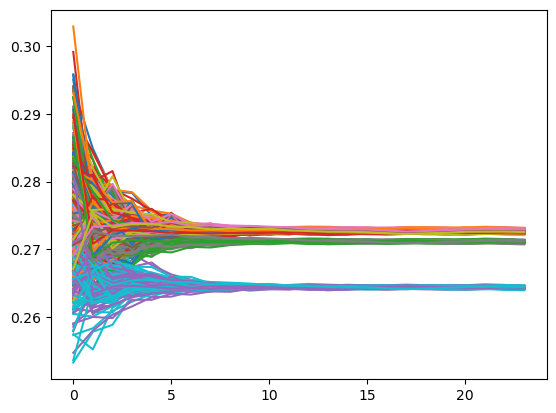

In [6]:
import matplotlib.pyplot as plt
# generated = timegan_generator(model, args)
for i in range(128): 
    plt.plot(generated[i,:])

In [2]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def visualization (ori_data, generated_data, analysis):
    """Using PCA or tSNE for generated and original data visualization.

    Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
    """  
    # Analysis sample size (for faster computation)
    anal_sample_no = min([1000, len(ori_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)  

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape  

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
        else:
            prep_data = np.concatenate((prep_data, 
                                      np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat, 
                                          np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))

    # Visualization parameter        
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)    
        plt.scatter(pca_results[:,0], pca_results[:,1],
                    c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
        plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                    c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

        ax.legend()  
        plt.title('PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y_pca')
        plt.show()

    elif analysis == 'tsne':

    # Do t-SNE Analysis together       
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
        tsne_results = tsne.fit_transform(prep_data_final)

    # Plotting
    f, ax = plt.subplots(1)

    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

    ax.legend()

    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()  

In [8]:
visualization(data, generated, 'tsne')

IndexError: index 2325 is out of bounds for axis 0 with size 128